In [3]:
import os
import time
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model

from joblib import load
from utils.visualize import showMe
from IPython.display import clear_output
import datetime
import brainflow
from scipy import signal

from brainflow.board_shim import BoardShim, BrainFlowInputParams, BoardIds, BrainFlowError

from tqdm.notebook import tqdm



from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split


%matplotlib inline



from utils.visualize import showMe
from utils.ros import connect, commands
from utils.record import preProcess, stat
from utils.svm import DCFilter, clip, remove2channel
from config.default import *

%load_ext autoreload
%autoreload 2

classes = settings['classes']
model_path = 'saved_models/svm_9subj_no_val.joblib'


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
ros, talker = connect()

In [4]:
####      INIT BOARD        #######
BoardShim.enable_dev_board_logger()
params = BrainFlowInputParams()
board = BoardShim(BoardIds.MINDROVE_WIFI_BOARD, params)


try:
    board.stop_stream()
    board.release_session()
except:
    ...
    
board.prepare_session()
sample_rate = board.get_sampling_rate(16)
print("Device ready (sampling rate: {}hz)".format(sample_rate))

Device ready (sampling rate: 500hz)


In [5]:
def predict(svm, sample):
    #sample = preProcess(sample, clip_value)
    sample = remove2channel(sample)
    sample = clip(sample, clip_value)

    prediction = svm.predict(sample.reshape(-1,4*500))[0]

    try:
        #######################################
        if int(prediction) == 1:
            talker.publish(commands['forward'])
        if int(prediction) == 2:
            talker.publish(commands['left'])
        if int(prediction) == 3:
            talker.publish(commands['right'])
        #######################################
    except Exception as e:
        print("No ROS Connection")
        
    prediction_class = classes[int(prediction)]
    
    showMe(sample)
    print(f'Prediction: {prediction_class}')
    return prediction_class

def JustDoIt():
    std_threshold = settings['std_threshold']
    cut = settings['clip_value']
    command_history = []
    print("Loading model...")

    svm = load(model_path)

  
    board.start_stream(450000)

    time.sleep(2)   #WAIT TO DC AVERAGE STAND IN
    print("Starting...")

    action_time = None
    block_time = None
    while True:
        time.sleep(0.001)
        data = board.get_current_board_data(sample_rate*settings['DC_length_control']) #10 seconds
        data = DCFilter(data)
        data = data[:6,-500:] #keep the data of the eeg channels only, and remove data over the trial length
        _, _, std = stat(data)
       
        
        if std == 0:
            print("[ERROR] No data collected! Check the MindRove device and try again.")
            break
        
        is_block = False
        if block_time is not None:
            is_block = datetime.datetime.now() < block_time
        if action_time is None and not is_block:
            if std > std_threshold:
                action_time  =  datetime.datetime.now()
                stop_time = action_time + datetime.timedelta(milliseconds=500*0.6)
        else:
            time_diff = (datetime.datetime.now() - stop_time).total_seconds()
            if abs(time_diff) < 0.01:
                clear_output()
                command_history.append(predict(svm, data))
                print(command_history)
                
                action_time = None
                block_time = datetime.datetime.now()+datetime.timedelta(milliseconds=1000)


No ROS Connection


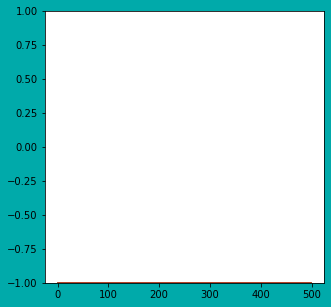

Prediction: Chew
['Chew', 'Smile', 'Rest', 'Smile', 'Chew', 'Eyebrow', 'Eyebrow', 'Eyebrow', 'Rest', 'Eyebrow', 'Chew', 'Smile', 'Chew', 'Smile', 'Rest', 'Smile', 'Chew', 'Eyebrow', 'Chew', 'Rest', 'Chew', 'Eyebrow', 'Chew', 'Rest', 'Chew', 'Chew', 'Chew', 'Rest', 'Chew', 'Rest', 'Chew', 'Smile', 'Chew', 'Chew', 'Eyebrow', 'Eyebrow', 'Rest', 'Smile', 'Eyebrow', 'Eyebrow', 'Chew', 'Chew', 'Chew', 'Chew', 'Chew', 'Chew', 'Chew']


KeyboardInterrupt: 

In [6]:
JustDoIt()

In [ ]:
def done():
    talker.unadvertise()
    ros.terminate()
    board.stop_stream()
    board.release_session()
done()